In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils
from code_utils import ordinal_regression


In [2]:
n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
 

In [4]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])


In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'ordinal_regression_withintask.npy')
# save_filename2 = os.path.join(save_folder, 'ordinal_regression_method2_withintask.npy')

dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()


dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'roi_names'])

In [6]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

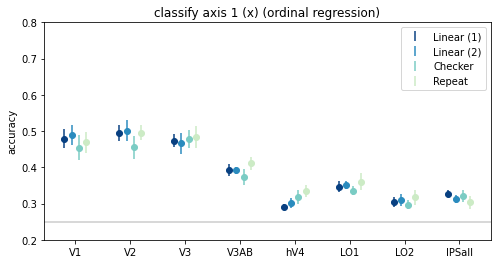

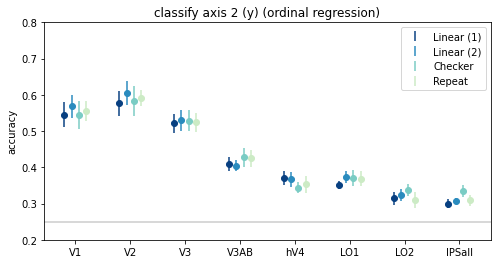

In [13]:
ti_plot = [0,1,2,3]
x_jitter = np.linspace(-0.2, 0.2, 4)

for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)']):

    plt.figure(figsize=(8,4));
    
    avals = dec_withintask['acc_bytask'][:,:,:,bi]

    plt.axhline(1/4, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0.2, 0.8])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('accuracy')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('classify %s (ordinal regression)'%axis_name)


#### visualize classifier output for one ROI

In [14]:
si = 5; ss=subjects[si]
ri = 0;
ti = 1; tt = 2;
ii = 1;

pred = dec_withintask['preds_all'][si][ri][ti][ii]
prob = dec_withintask['probs_all'][si][ri][ti][ii]
 
# "confidence" in assignment to category 2 vs 1
pdiff = (prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0])
# pdiff = (prob[:,2]) - (prob[:,1])

l = lab[ss][lab[ss]['task']==tt]

pt_labs = np.array([l['ptx'], l['pty']]).T
is_main_grid = np.array(l['is_main_grid']==1)

# actual labels for position along this axis
coord_actual = pt_labs[:,ii]

# is it a hard trial?
is_hard = ~is_main_grid

# was the subject correct or incorrect?
correct = np.array(l['subject_correct'])

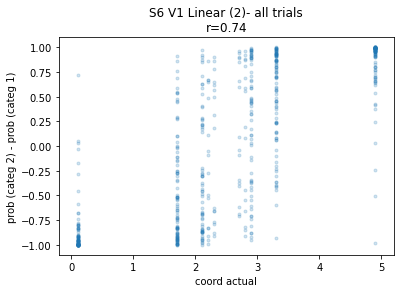

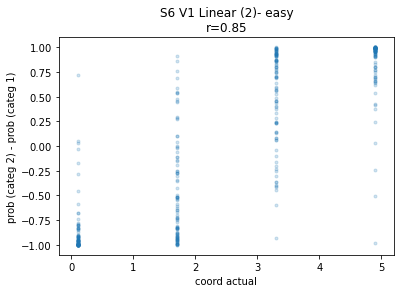

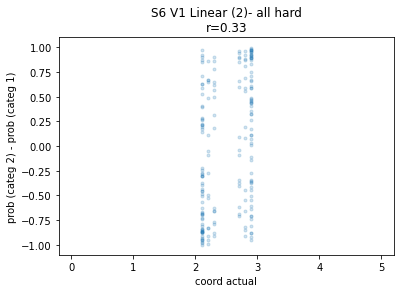

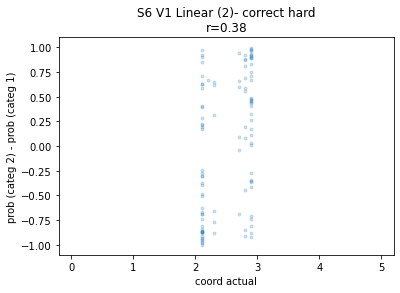

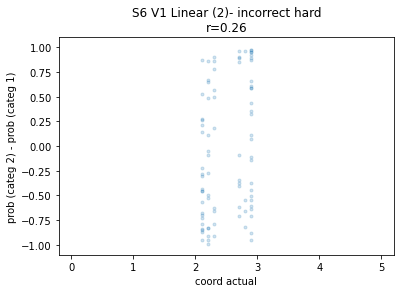

In [15]:

for inds, name in zip([np.ones(np.shape(is_hard),dtype=bool), \
                       ~is_hard, is_hard, is_hard & correct, is_hard & ~correct], \
                      ['all trials', 'easy', 'all hard','correct hard','incorrect hard']):
    plt.figure()

    plt.plot(coord_actual[inds], pdiff[inds], '.', alpha=0.2)
    plt.xlabel('coord actual')
    plt.ylabel('prob (categ 2) - prob (categ 1)')
    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
    plt.title('S%d %s %s- %s\nr=%.2f'%(subjects[si], roi_names[ri], task_names[ti], name, r));
    plt.xlim([-0.2, 5.2])
    plt.ylim([-1.1, 1.1])

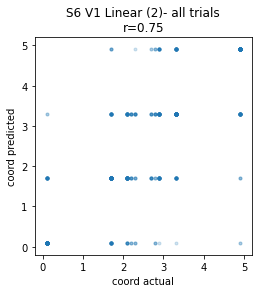

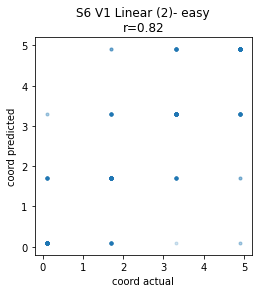

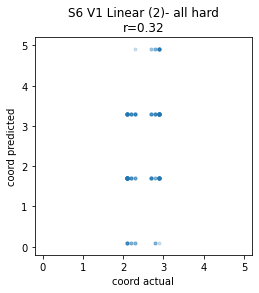

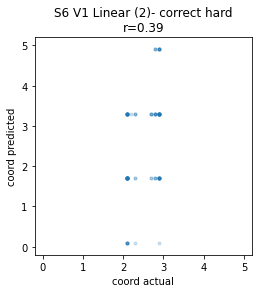

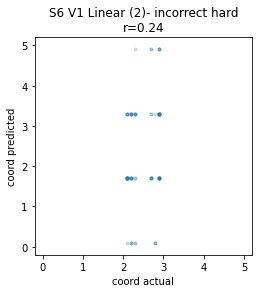

In [16]:

for inds, name in zip([np.ones(np.shape(is_hard),dtype=bool), \
                       ~is_hard, is_hard, is_hard & correct, is_hard & ~correct], \
                      ['all trials', 'easy', 'all hard','correct hard','incorrect hard']):
    plt.figure()

    plt.plot(coord_actual[inds], pred[inds], '.', alpha=0.2)
    plt.xlabel('coord actual')
    plt.ylabel('coord predicted')
    r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
    plt.title('S%d %s %s- %s\nr=%.2f'%(subjects[si], roi_names[ri], task_names[ti], name, r));
    plt.axis('square')
    plt.xlim([-0.2, 5.2])
    plt.ylim([-0.2, 5.2])
    

#### compute how accurate the predictions are

In [29]:
r_allmaintrials = np.zeros((n_subjects, n_rois, 2, 2))
conf_allmaintrials = np.zeros((n_subjects, n_rois, 2, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, 2, 2))

r_easytrials = np.zeros((n_subjects, n_rois, 2, 2))
conf_easytrials = np.zeros((n_subjects, n_rois, 2, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, 2, 2))

r_medtrials = np.zeros((n_subjects, n_rois, 2, 2))
conf_medtrials = np.zeros((n_subjects, n_rois, 2, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, 2, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)
        
        for ii in [0,1]:
            
            # actual labels for position along this axis
            coord_actual = pt_labs[:,ii]
            center = 2.5
            categ_actual = (coord_actual>center).astype(int) + 1
            
            # hard trials are closest to bound (variable grid)
            # easy is the furthest from bound
            # medium is second furthest
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            is_hard = dist_from_center<0.8
            is_easy = dist_from_center==2.4
            is_medium = dist_from_center==0.8
            
            # print([ti,ii])
            # print(np.sum(is_hard), np.sum(is_medium), np.sum(is_easy))
            # print([ti, ii, np.mean(in_center)])
                 
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti][ii]
                assert(np.all(np.isin(pred, coord_actual)))
                # assert(np.all(np.isin(coord_actual, pred)))
                       
    
                categ_pred = (pred>center).astype(int) + 1
                
                       
                prob = dec_withintask['probs_all'][si][ri][ti][ii]
      
                p_categ2 = (prob[:,3]+prob[:,2])
                p_categ1 = (prob[:,1]+prob[:,0])
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

                    
                # print(np.mean(prob<0))
                # all trials
                inds = is_main_grid
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_allmaintrials[si,ri,ti,ii] = r;
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                       
                # easy trials
                inds = is_easy
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_easytrials[si,ri,ti,ii] = r;
                
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
                
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_medtrials[si,ri,ti,ii] = r;
                
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
                
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

#### for each task, plot how well the classifier predicts coordinate

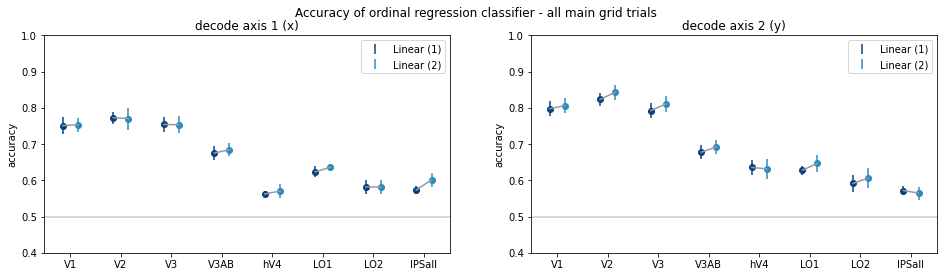

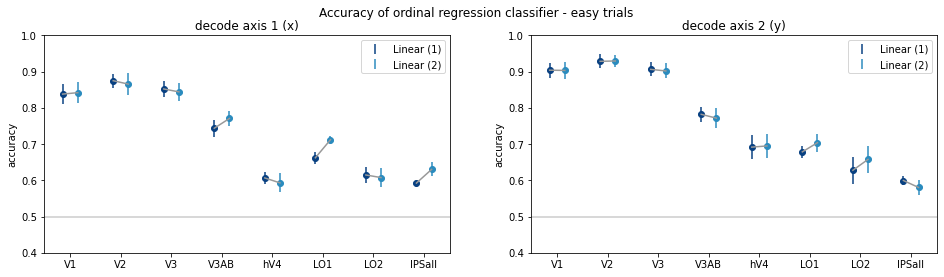

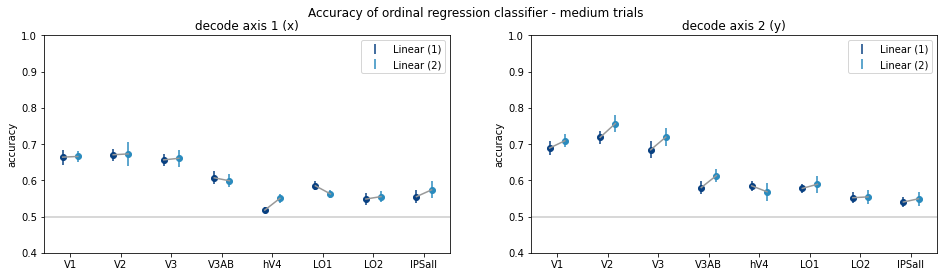

In [31]:
x_jitter = [-0.15, 0.15]

for avals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
# for rvals, name in zip([pr_easytrials, pr_medtrials, pr_hardtrials_centeronly], \
#                      ['easy trials','medium trials', 'hard trials, center only']):

    plt.figure(figsize=(16, 4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        colors = task_colors[0:2,:]

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti, tt in enumerate([1,2]):

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,:,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.ylim([0.4, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,task_names[0:2])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Accuracy of ordinal regression classifier - %s'%name)


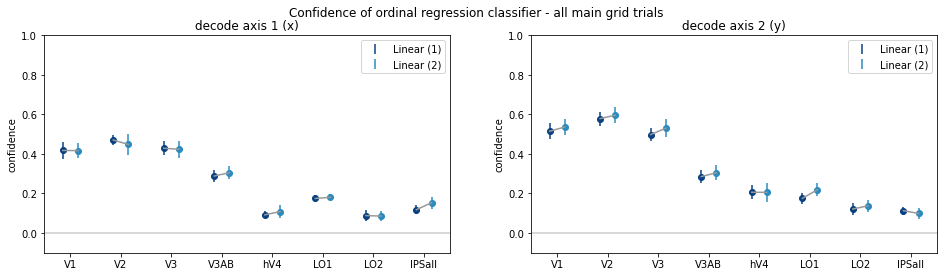

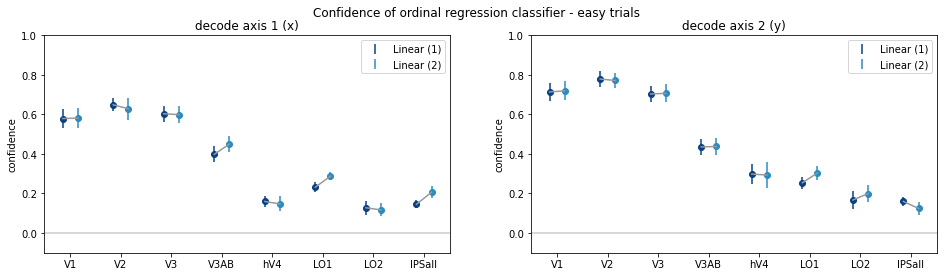

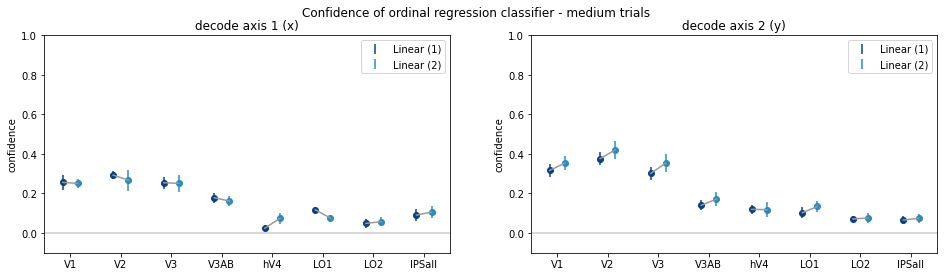

In [38]:
x_jitter = [-0.15, 0.15]

for cvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
# for rvals, name in zip([pr_easytrials, pr_medtrials, pr_hardtrials_centeronly], \
#                      ['easy trials','medium trials', 'hard trials, center only']):

    plt.figure(figsize=(16, 4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        colors = task_colors[0:2,:]

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti, tt in enumerate([1,2]):

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = cvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(cvals[:,ri,:,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.ylim([-0.1, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,task_names[0:2])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Confidence of ordinal regression classifier - %s'%name)


#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [8]:
n_coord_bins = 12;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

# n_boot_iter =2;
n_boot_iter = 1000;
n_boot_samp = 100;

dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):
    
    print(si)

    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)
        
        ii = ti; # focusing on the task-relevant axis here
        
        # is it a hard trial?
        is_hard = ~is_main_grid
        
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
    
        print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
        
        # loop over correct/incorrect trials
        for ci, inds in enumerate([inds1, inds2]):

            nt = len(inds)
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
                
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # get predictions from each ROI, these trials
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti][ii]
                    prob = dec_withintask['probs_all'][si][ri][ti][ii]

                    p_categ2 = (prob[:,3]+prob[:,2])
                    p_categ1 = (prob[:,1]+prob[:,0])
                   
                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                   
                    # binarize the classifier's prediction
                    center = 2.5
                    categ_pred = (pred>center).astype(int) + 1

                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = d

                    signedconf_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = np.mean(signedconf[inds_resamp])



0
[2 3 4 5 6 7 8 9] [ 8 26 30  7  7 14 11  3]
[3 4 5 6 7 8 9] [ 6 10  9  9 26 21  5]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
26 17
30 17
7 17
7 17
14 17
11 17
6 17
10 17
9 17
9 17
26 17
21 17
[3 4 5 6 7 8] [ 8 14 30 26 24 14]
[3 4 5 6 7 8] [ 8 18 18 22  8  2]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
8 17
14 17
30 17
26 17
24 17
14 17
8 17
18 17
18 17
22 17
8 17
2 17
1
[2 3 4 5 6 7 8 9] [ 6 27 11  2  7 26 37  7]
[2 3 4 5 6 7 8 9] [ 2 21 21  6  1  6 11  1]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
6 13
27 13
11 13
2 13
7 13
26 13
37 13
7 13
2 13
21 13
21 13
6 13
1 13
6 13
11 13
1 13
[2 3 4 7 8 9] [11 23  9 21 43 11]
[2 3 4 7 8 9] [ 5 33 15  3 13  5]
[ 0.47  0.33  0.2  -0.2  -0.33 -0.47] [ 0.47  0.33  0.2  -0.2  -0.33 -0

#### plot the confidence intervals for correct vs incorrect

Text(0.5, 0.98, 'Classifier confidence, median +/- bootstrapped 95 CI')

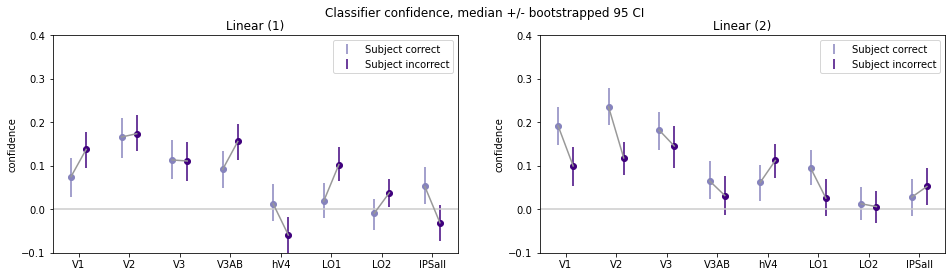

In [10]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    signedconf_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.4])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Classifier confidence, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'dprime for hard trials, median +/- bootstrapped 95 CI')

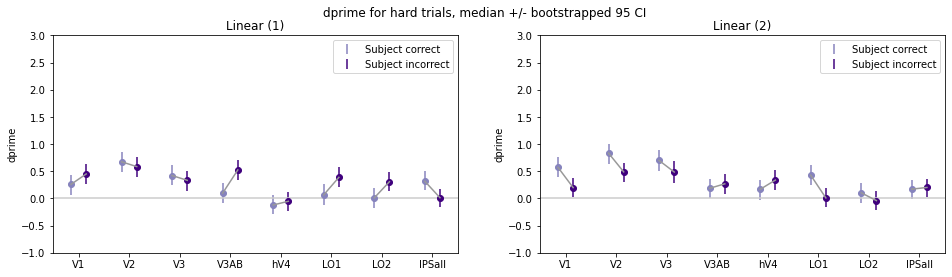

In [11]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([dprime_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    dprime_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-1, 3])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('dprime')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('dprime for hard trials, median +/- bootstrapped 95 CI')


#### other things to try...we can break the trials down by distance from the boundary?
this is tricky because not every subject sees every distance level

In [443]:
center_range = [1.7, 3.3]
center = 2.5

r_alltrials = np.zeros((n_subjects, n_rois, 2, 2))
r_easytrials = np.zeros((n_subjects, n_rois, 2, 2))
r_hardtrials = np.zeros((n_subjects, n_rois, 2, 2))
pr_hardtrials = np.zeros((n_subjects, n_rois, 2, 2))

r_hardtrials_centeronly = np.zeros((n_subjects, n_rois, 2, 2))
pr_hardtrials_centeronly = np.zeros((n_subjects, n_rois, 2, 2))

pr_hardtrials_correct = np.zeros((n_subjects, n_rois, 2))
pr_hardtrials_incorrect = np.zeros((n_subjects, n_rois, 2))

dprime_hardtrials_correct = np.zeros((n_subjects, n_rois, 2))
dprime_hardtrials_incorrect = np.zeros((n_subjects, n_rois, 2))

diff_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 2.4]
n_diff = len(diff_vals)
pr_diffbins_all = np.zeros((n_subjects, n_rois, 2, n_diff))
pr_diffbins_correct = np.zeros((n_subjects, n_rois, 2, n_diff))
pr_diffbins_incorrect = np.zeros((n_subjects, n_rois, 2, n_diff))

counts_diffbins_all = np.zeros((n_subjects, 2, n_diff))
counts_diffbins_correct = np.zeros((n_subjects,  2, n_diff))
counts_diffbins_incorrect = np.zeros((n_subjects,  2, n_diff))

dprime_diffbins_all = np.zeros((n_subjects, n_rois, 2, n_diff))
dprime_diffbins_correct = np.zeros((n_subjects, n_rois, 2, n_diff))
dprime_diffbins_incorrect = np.zeros((n_subjects, n_rois, 2, n_diff))

for si, ss in enumerate(subjects):

    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    concat_labels = pd.concat([main_labels, rep_labels], axis=0)
    pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
    is_main_grid = concat_labels['is_main_grid']==1
    
    for ti, tt in enumerate([1,2]):
        
        for ii in [0,1]:

            task_inds = concat_labels['task']==tt

            # actual labels for position along this axis
            coord_actual = np.array(pt_labs[:,ii])[task_inds]

            
            # is it a hard trial?
            is_hard = ~is_main_grid[task_inds]
            
            in_center = (coord_actual>center_range[0]) & (coord_actual<center_range[1])
            # print([ti, ii, np.mean(in_center)])
            
            if ii==ti:

                # which side of boundary was point? 1 = <center, 2=>center
                categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)
                categ_check = (coord_actual>center).astype(int) + 1
                assert(np.all(categ_actual==categ_check))

                # what category did the subject respond? 
                categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
                categ_subjresp[np.abs(categ_subjresp)>2] = 0;

                # was the subject correct or incorrect?
                correct = categ_subjresp==categ_actual
                
                difficulty = np.abs(coord_actual-center).round(2)
                assert(np.all(np.isin(difficulty, diff_vals)))
                       
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti][ii]
                prob = dec_withintask['probs_all'][si][ri][ti][ii]
                
                # "confidence" in assignment to category 2 vs 1
                pdiff = (prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0])
                # pdiff = (prob[:,2]) - (prob[:,1])
                
                categ_pred = (pred>center).astype(int) + 1
                    
                # print(np.mean(prob<0))
                # all trials
                r,p = scipy.stats.pearsonr(coord_actual, pred)
                r_alltrials[si,ri,ti,ii] = r;
                
                # easy trials
                inds = ~is_hard
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_easytrials[si,ri,ti,ii] = r;
                
                # hard trials
                inds = is_hard
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_hardtrials[si,ri,ti,ii] = r;
               
                inds = is_hard
                # compute the probability difference for right side - left side
                
                r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                pr_hardtrials[si,ri,ti,ii] = r;
            
                # to make things fair across tasks, can take just the center points
                inds = is_hard & in_center
                r,p = scipy.stats.pearsonr(coord_actual[inds], pred[inds])
                r_hardtrials_centeronly[si,ri,ti,ii] = r;
               
                inds = is_hard & in_center
                r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                pr_hardtrials_centeronly[si,ri,ti,ii] = r;
               
                # separate by incorrect/correct (only doing this for task-relevant axis)
                if ii==ti:
                    
                    inds = is_hard & correct
                    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                    pr_hardtrials_correct[si,ri,ti] = r;

                    d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                    dprime_hardtrials_correct[si,ri,ti] = d
                    
                    inds = is_hard & ~correct
                    r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                    pr_hardtrials_incorrect[si,ri,ti] = r;
                
                    d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                    dprime_hardtrials_incorrect[si,ri,ti] = d
                    
                    # break the trials down further into "difficulty" bins
                    # this is important to make correct/incorrect comparisons fair
                    for di, diff in enumerate(diff_vals):
                        
                        inds = (difficulty==diff)
                        counts_diffbins_all[si,ti,di] = np.sum(inds)
                        if np.sum(inds)<2:
                            pr_diffbins_all[si,ri,ti,di] = np.nan
                            dprime_diffbins_all[si,ri,ti,di] = np.nan
                        else:
                            r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                            pr_diffbins_all[si,ri,ti,di] = r;

                            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                            dprime_diffbins_all[si,ri,ti,di] = d

                        inds = correct & (difficulty==diff)
                        counts_diffbins_correct[si,ti,di] = np.sum(inds)
                        if np.sum(inds)<2:
                            pr_diffbins_correct[si,ri,ti,di] = np.nan
                            dprime_diffbins_correct[si,ri,ti,di] = np.nan
                        else:
                            r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                            pr_diffbins_correct[si,ri,ti,di] = r;

                            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                            dprime_diffbins_correct[si,ri,ti,di] = d

                        inds = ~correct & (difficulty==diff)
                        counts_diffbins_incorrect[si,ti,di] = np.sum(inds)
                        if np.sum(inds)<2:
                            pr_diffbins_incorrect[si,ri,ti,di] = np.nan
                            dprime_diffbins_incorrect[si,ri,ti,di] = np.nan
                        else:
                            r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff[inds])
                            pr_diffbins_incorrect[si,ri,ti,di] = r;

                            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                            dprime_diffbins_incorrect[si,ri,ti,di] = d

                        

/home/AD/mmhender/anaconda3/envs/shapedim/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/AD/mmhender/anaconda3/envs/shapedim/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/home/AD/mmhender/anaconda3/envs/shapedim/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/AD/mmhender/anaconda3/envs/shapedim/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [449]:
for di in [0,1,2,3,4,5,6]:
    
    print(diff_vals[di])
    print(counts_diffbins_correct[:,:,di])
    print(counts_diffbins_incorrect[:,:,di])

0.1
[[14. 56.]
 [ 9.  0.]
 [22. 21.]
 [ 0.  0.]
 [ 0. 22.]
 [ 0.  0.]
 [ 0.  0.]]
[[18. 40.]
 [ 7.  0.]
 [10. 11.]
 [ 0.  0.]
 [ 0. 26.]
 [ 0.  0.]
 [ 0.  0.]]
0.2
[[44. 38.]
 [37. 30.]
 [21. 36.]
 [ 0.  0.]
 [ 0. 23.]
 [16. 12.]
 [ 0.  0.]]
[[36. 26.]
 [27. 18.]
 [11. 12.]
 [ 0.  0.]
 [ 0. 25.]
 [16. 20.]
 [ 0.  0.]]
0.3
[[37. 10.]
 [38. 58.]
 [31.  0.]
 [ 0. 32.]
 [48. 34.]
 [26. 13.]
 [ 0.  0.]]
[[27.  6.]
 [26. 38.]
 [17.  0.]
 [ 0. 16.]
 [32. 14.]
 [22. 19.]
 [ 0.  0.]]
0.4
[[ 0. 12.]
 [26.  8.]
 [34. 45.]
 [21. 23.]
 [63. 25.]
 [43. 80.]
 [ 1. 31.]]
[[ 0.  4.]
 [ 6.  8.]
 [14. 19.]
 [11.  9.]
 [33.  7.]
 [37. 48.]
 [15. 17.]]
0.5
[[ 11.   0.]
 [ 13.  22.]
 [ 21.  40.]
 [109.  77.]
 [ 10.  13.]
 [  0.   0.]
 [ 92. 100.]]
[[ 5.  0.]
 [ 3. 10.]
 [11.  8.]
 [51. 35.]
 [ 6.  3.]
 [ 0.  0.]
 [84. 44.]]
0.8
[[156. 163.]
 [159. 160.]
 [160. 161.]
 [142. 152.]
 [147. 176.]
 [118. 149.]
 [122. 159.]]
[[36. 29.]
 [33. 32.]
 [32. 31.]
 [50. 40.]
 [45. 16.]
 [42. 43.]
 [70. 33.]]
2.4
[[184. 1

In [427]:
dprime_diffbins_incorrect.shape

(7, 8, 2, 7)

In [425]:
np.mean(np.isnan(pr_diffbins_incorrect))

0.2653061224489796

In [421]:
np.sum(inds)

1

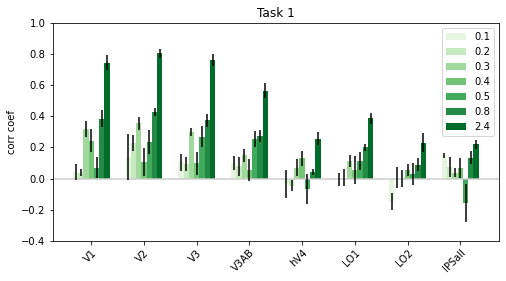

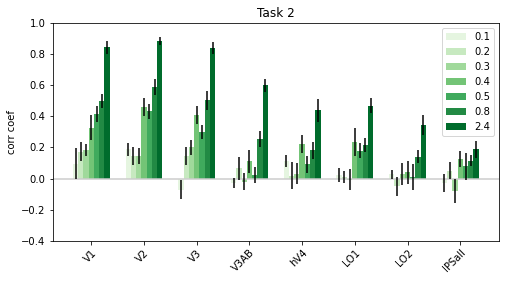

In [ ]:
for ti in [0,1]:
    
    tt = ti+1

    colors = cm.Greens(np.linspace(0,1,9))[1:9,:]

    vals = pr_diffbins_all[:,:,ti,:]
    
    meanvals = np.nanmean(vals, axis=0)
    semvals = np.nanstd(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               # add_ss_lines=False,
                               colors = colors, \
                               space = 0.15, \
                               title = 'Task %d'%(tt), \
                               ylim = [-0.4, 1.0], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'corr coef', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = diff_vals, \
                               fig_size=(8,4));

In [433]:
pr_diffbins_correct.shape

(7, 8, 2, 7)

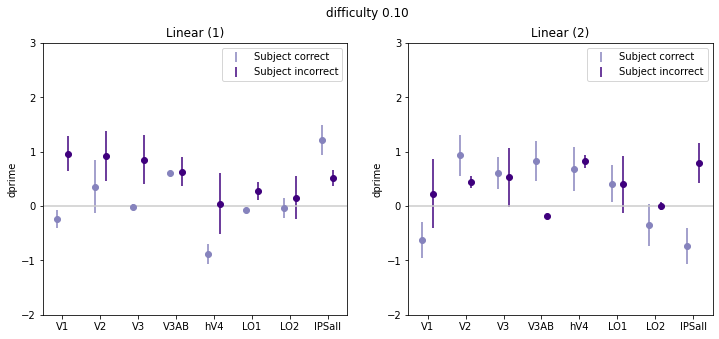

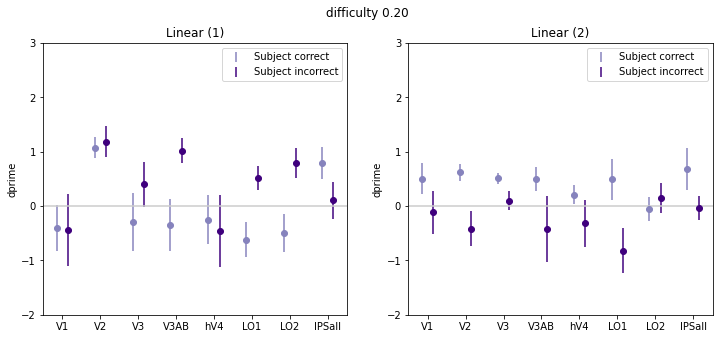

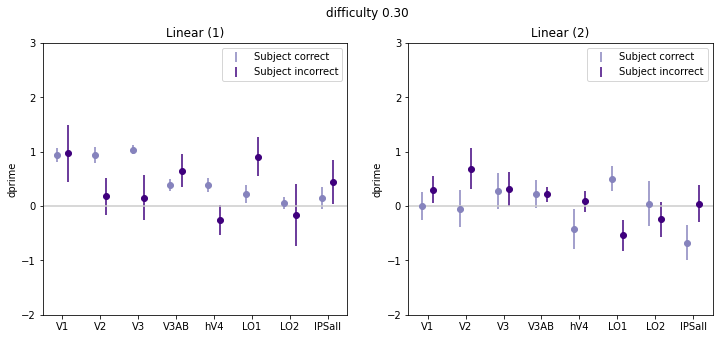

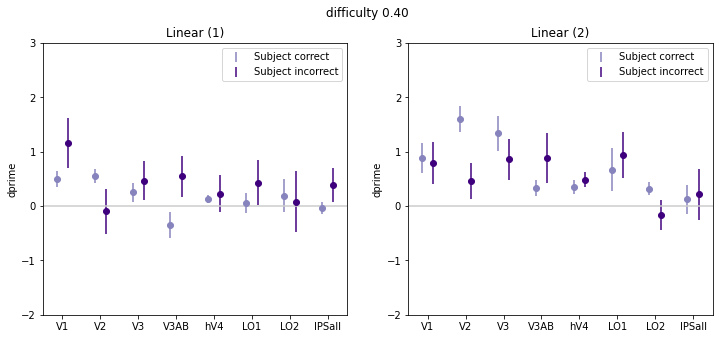

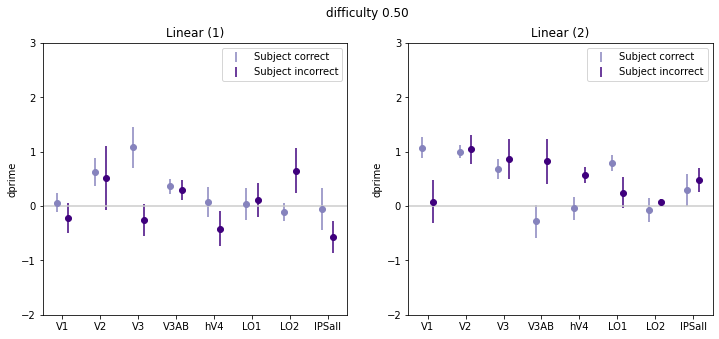

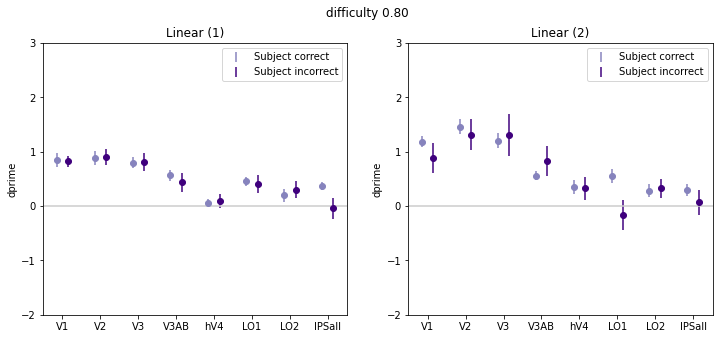

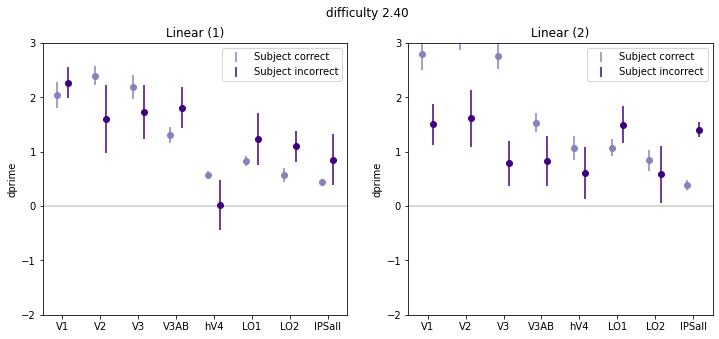

In [439]:
x_jitter = [-0.15, 0.15]

for di, diff in enumerate(diff_vals):

    plt.figure(figsize=(12,5))

    for ti, tt in enumerate([1,2]):

        plt.subplot(1,2,tt)

        colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ci, vals in enumerate([dprime_diffbins_correct[:,:,ti,di], \
                                    dprime_diffbins_incorrect[:,:,ti,di]]):

            x_ticks = np.arange(n_rois) + x_jitter[ci]
                                   
            meanvals = np.nanmean(vals, axis=0)
            semvals = np.nanstd(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[ci])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ci], linestyle='none')
            lh.append(h)

        plt.ylim([-2.0, 3.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('dprime')

        plt.legend(lh,['Subject correct','Subject incorrect'])

        plt.title(task_names[ti])

    plt.suptitle('difficulty %.2f'%diff)


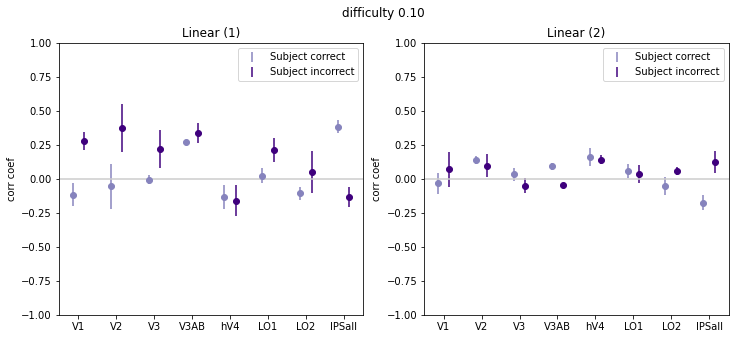

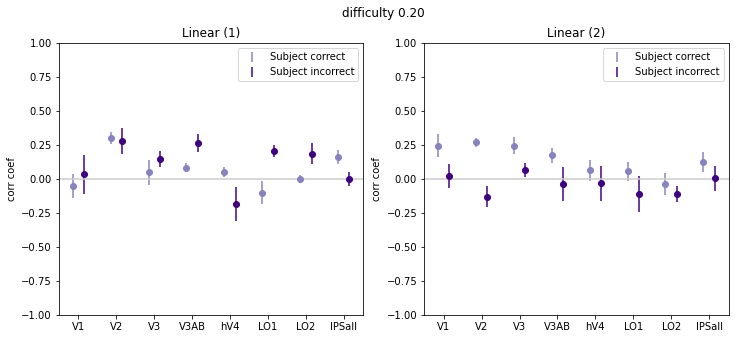

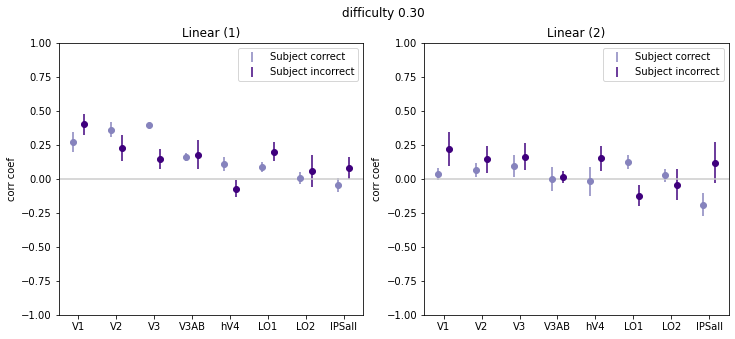

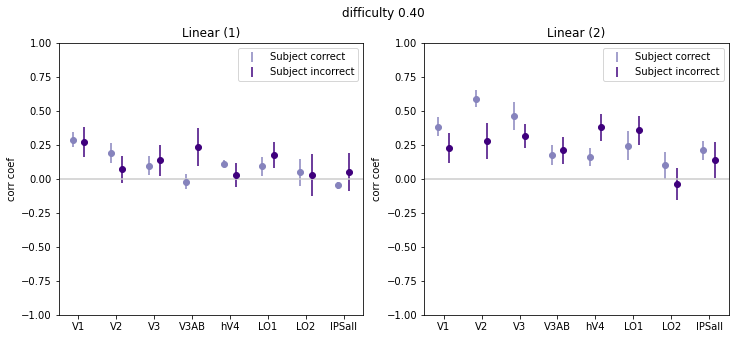

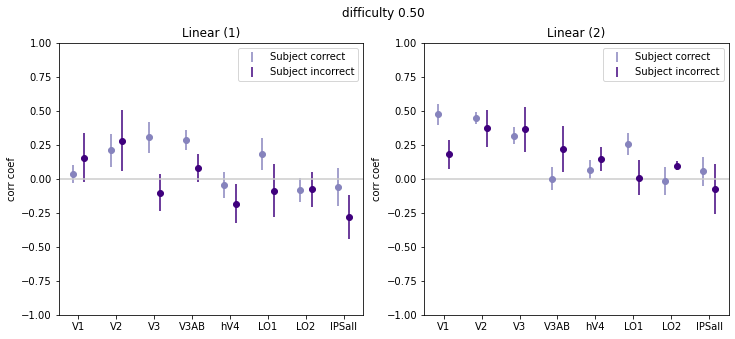

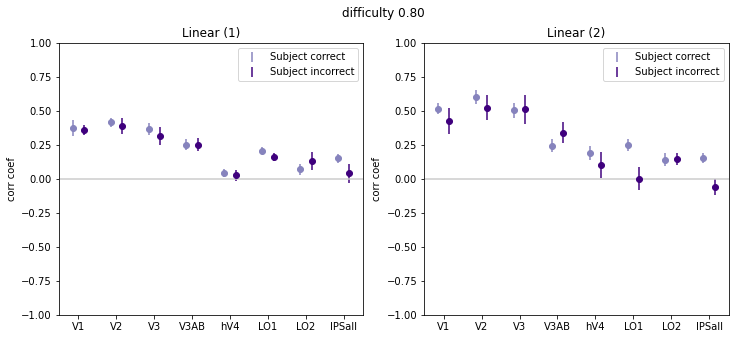

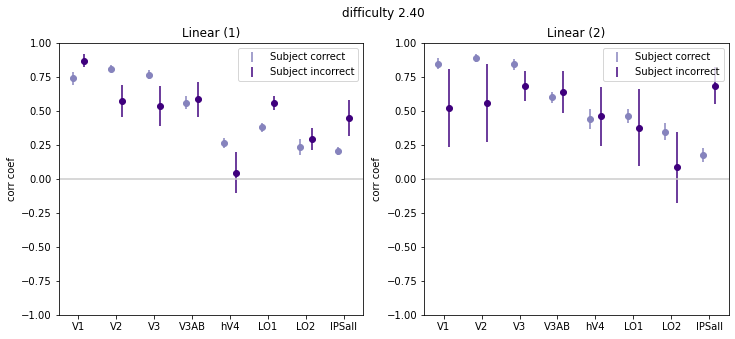

In [437]:
x_jitter = [-0.15, 0.15]

for di, diff in enumerate(diff_vals):

    plt.figure(figsize=(12,5))

    for ti, tt in enumerate([1,2]):

        plt.subplot(1,2,tt)

        colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ci, vals in enumerate([pr_diffbins_correct[:,:,ti,di], \
                                    pr_diffbins_incorrect[:,:,ti,di]]):

            x_ticks = np.arange(n_rois) + x_jitter[ci]
                                   
            meanvals = np.nanmean(vals, axis=0)
            semvals = np.nanstd(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[ci])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[ci], linestyle='none')
            lh.append(h)

        plt.ylim([-1.0, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('corr coef')

        plt.legend(lh,['Subject correct','Subject incorrect'])

        plt.title(task_names[ti])

    plt.suptitle('difficulty %.2f'%diff)


In [393]:
boot_vals.shape

(7, 8, 1000)

In [391]:
boot_pct.shape

(3, 7, 8)

In [390]:
upper_vals

array([0.08612172, 0.0830961 , 0.07809278, 0.08710906, 0.08675721,
       0.08262995, 0.08191618, 0.09040547])

In [373]:
boot_vals.shape

(7, 8, 1000)

In [369]:
boot_pct1 = np.percentile(pr_hardtrials_correct_boot, [2.5, 50, 97.5], axis=3)
boot_pct2 = np.percentile(pr_hardtrials_incorrect_boot, [2.5, 50, 97.5], axis=3)
boot_pct1.shape

(3, 7, 8, 2)

In [359]:
inds_resamp

array([421, 377, 574, 454, 450, 107, 393, 465, 399, 560, 469, 154, 354,
       347,  66, 347, 377,   1, 423, 296, 431,  97, 355, 490, 428, 195,
       347, 497, 355,  58, 318, 318, 205, 253, 574, 222, 439, 500, 469,
       253, 353, 354,  80, 516,  66,  85, 449,  26,  88, 110, 182, 471,
        97,  97, 145, 397,  48, 454,  93, 459, 179, 393,  20, 410, 189,
       103, 494, 264, 211, 332,  29, 318, 382, 439, 136, 303,  80, 548,
        26, 393, 449,  91, 454, 536, 353, 565, 106, 181, 182, 103, 410,
        29,  88, 189, 360,  30,  48, 353, 181, 387,   1, 205, 336, 245,
       260, 476, 211, 296, 548, 469,  49, 238, 471, 427, 110, 423, 253,
       428,  91, 197, 450,  30, 222, 510, 490, 205, 417, 107, 449, 379,
       439, 421, 445, 490, 347,  66, 421, 332, 428, 445, 136, 439, 142,
       410, 397, 382, 476, 360,  80,  14,  37, 459, 516, 160, 251, 382,
       339, 484, 497,  91, 449, 195, 290, 107, 312, 523, 536, 471, 264,
       251,  75, 382, 280,  44, 115, 423, 449, 511, 290, 399, 53

In [358]:
pr_hardtrials_correct_boot[0,0,0,:]

array([-0.05261464,  0.05212652])

#### try pooling across subjects

In [217]:
pr_hardtrials_correct = np.zeros((n_rois, 2))
pr_hardtrials_incorrect = np.zeros((n_rois, 2))

for ri in range(n_rois):
    
    for ti,tt in enumerate([1,2]):

        actual_coord = []
        pdiff = []
        correct = []
        is_hard = []

        for si, ss in enumerate(subjects):

            # get labels for all the trials, this subjct
            main_labels = data_utils.load_main_task_labels(ss)
            rep_labels = data_utils.load_repeat_task_labels(ss)

            concat_labels = pd.concat([main_labels, rep_labels], axis=0)
            pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
            is_main_grid = concat_labels['is_main_grid']==1

            task_inds = concat_labels['task']==tt

            hard = ~is_main_grid[task_inds]

            # actual labels for position along this axis
            ii = ti;
            coord_actual = np.array(pt_labs[:,ii])[task_inds]

            # which side of boundary was point? 1 = <center, 2=>center
            categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)

            center = 2.5
            categ_check = (coord_actual>center).astype(int) + 1

            assert(np.all(categ_actual==categ_check))

            # what category did the subject respond? 
            categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
            categ_subjresp[np.abs(categ_subjresp)>2] = 0;

            # was the subject correct or incorrect?
            corr = categ_subjresp==categ_actual

            prob = dec_withintask['probs_all'][si][ri][ti][ii]


            actual_coord.append(coord_actual)

            pdiff.append((prob[:,3]+prob[:,2]) - (prob[:,1]+prob[:,0]))
            # pdiff.append((prob[:,2]) - (prob[:,1]))

            correct.append(corr)

            is_hard.append(hard)


        actual_coord = np.concatenate(actual_coord, axis=0)
        pdiff = np.concatenate(pdiff, axis=0)
        correct = np.concatenate(correct, axis=0)
        is_hard = np.concatenate(is_hard, axis=0)

        inds = is_hard & correct
        r,p = scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])
        pr_hardtrials_correct[ri,ti] = r;

        inds = is_hard & ~correct
        r,p = scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])
        pr_hardtrials_incorrect[ri,ti] = r;

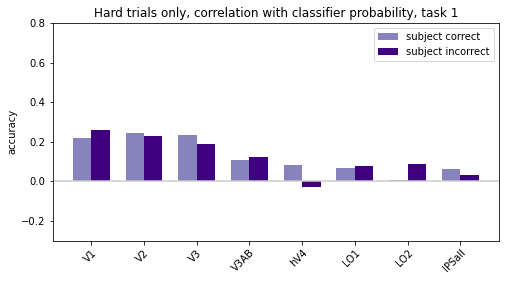

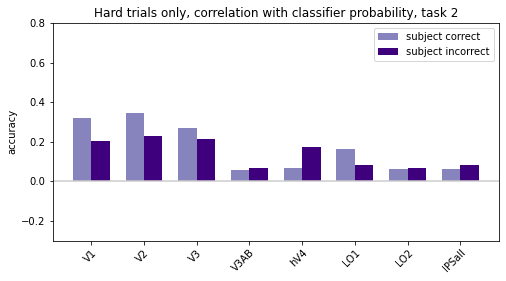

In [219]:
for ti in [0,1]:

    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    vals = np.concatenate([pr_hardtrials_correct[:,ti:ti+1], pr_hardtrials_incorrect[:,ti:ti+1]], axis=1)

    meanvals = vals
    semvals = []

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               add_ss_lines=False,
                               colors = colors, \
                               space = 0.15, \
                               title = 'Hard trials only, correlation with classifier probability, task %d'%(ti+1), \
                               ylim = [-0.3, 0.8], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'accuracy', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = ['subject correct', 'subject incorrect'], \
                              fig_size=(8,4));

(0.1380523229090388, 5.173753452272178e-07)

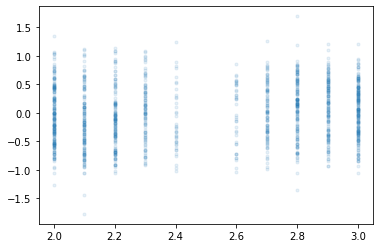

In [179]:
plt.figure()
inds = is_hard
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

861


(0.023713608282715272, 0.487111362592837)

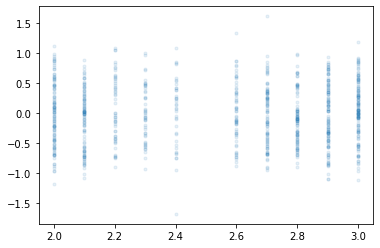

In [183]:
plt.figure()
inds = is_hard & correct
print(np.sum(inds))
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

483


(0.11455461804247008, 0.011756436965752527)

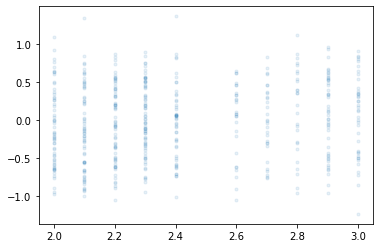

In [177]:
plt.figure()
inds = is_hard & ~correct
print(np.sum(inds))
plt.plot(actual_coord[inds], pdiff[inds],'.', alpha=0.1)
scipy.stats.pearsonr(actual_coord[inds], pdiff[inds])

In [149]:
categ_actual

array([2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1,

In [136]:
pred

array([4.9, 1.7, 1.7, 3.3, 4.9, 3.3, 1.7, 0.1, 1.7, 1.7, 3.3, 0.1, 1.7,
       4.9, 0.1, 3.3, 3.3, 3.3, 0.1, 3.3, 3.3, 3.3, 1.7, 1.7, 1.7, 0.1,
       3.3, 1.7, 1.7, 4.9, 3.3, 4.9, 3.3, 3.3, 0.1, 4.9, 3.3, 3.3, 0.1,
       1.7, 1.7, 4.9, 1.7, 3.3, 3.3, 4.9, 3.3, 3.3, 4.9, 4.9, 4.9, 3.3,
       0.1, 0.1, 3.3, 3.3, 1.7, 1.7, 3.3, 0.1, 1.7, 0.1, 1.7, 4.9, 1.7,
       1.7, 3.3, 4.9, 3.3, 4.9, 1.7, 4.9, 0.1, 4.9, 1.7, 1.7, 3.3, 3.3,
       0.1, 4.9, 1.7, 4.9, 4.9, 3.3, 0.1, 4.9, 1.7, 1.7, 3.3, 4.9, 1.7,
       3.3, 1.7, 1.7, 0.1, 3.3, 1.7, 3.3, 3.3, 0.1, 4.9, 3.3, 1.7, 0.1,
       0.1, 0.1, 3.3, 3.3, 3.3, 1.7, 4.9, 0.1, 0.1, 0.1, 1.7, 4.9, 1.7,
       0.1, 3.3, 3.3, 4.9, 1.7, 1.7, 3.3, 1.7, 4.9, 3.3, 4.9, 4.9, 1.7,
       4.9, 0.1, 0.1, 0.1, 3.3, 0.1, 1.7, 3.3, 1.7, 4.9, 3.3, 3.3, 0.1,
       1.7, 3.3, 1.7, 1.7, 1.7, 0.1, 1.7, 0.1, 1.7, 0.1, 3.3, 1.7, 3.3,
       1.7, 3.3, 3.3, 3.3, 1.7, 0.1, 1.7, 4.9, 0.1, 1.7, 0.1, 3.3, 3.3,
       4.9, 3.3, 0.1, 3.3, 3.3, 1.7, 0.1, 0.1, 4.9, 3.3, 1.7, 3.

In [110]:
# for si, ss in enumerate(subjects):
si = 0; ss = 1;

# get labels for all the trials, this subjct
main_labels = data_utils.load_main_task_labels(ss)
rep_labels = data_utils.load_repeat_task_labels(ss)
concat_labels = pd.concat([main_labels, rep_labels], axis=0)
pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
is_main_grid = concat_labels['is_main_grid']==1
grid_pts, grid_labs_main, counts = np.unique(pt_labs[is_main_grid], axis=0, return_inverse=True, return_counts=True)

# for ti, tt in enumerate([1,2]):

ti = 0; tt = 1;
ii = 1;
# ii = ti; # only consider same axis that was relevant in this task

task_inds = concat_labels['task']==tt

# actual labels for position along this axis
coord_actual = np.array(pt_labs[:,ii])[task_inds]
# which side of boundary was point? 1 = <center, 2=>center
categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)

center = 2.5
categ_check = (coord_actual>center).astype(int) + 1

# assert(np.all(categ_actual==categ_check))

# what category did the subject respond? 
categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)
categ_subjresp[np.abs(categ_subjresp)>2] = 0;

# was the subject correct or incorrect?
# correct = categ_subjresp==categ_actual

# is it a hard trial?
is_hard = ~is_main_grid[task_inds]

ri = 0;
# for ri in range(n_rois):

pred = dec_withintask['preds_all'][si][ri][ti][ii]
prob = dec_withintask['probs_all'][si][ri][ti][ii]

# convert the classifier's prediction to binary category
categ_classpred = (pred>1).astype(int)+1

acc_easy = np.mean(categ_actual[~is_hard]==categ_classpred[~is_hard])
acc_hard = np.mean(categ_actual[is_hard]==categ_classpred[is_hard])

# inds = is_hard & correct

# pdiff = prob[inds,3] - prob[inds,0]

# r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)

# r_hardtrials_correct[si,ri,ti] = r;


# inds = is_hard & ~correct

# pdiff = prob[inds,3] - prob[inds,0]

# r,p = scipy.stats.pearsonr(coord_actual[inds], pdiff)

# r_hardtrials_incorrect[si,ri,ti] = r;


(0.5514010233656854, 3.9833945609404763e-47)


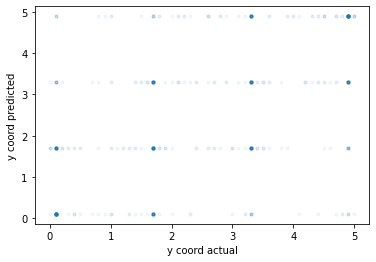

In [112]:
plt.figure()
plt.plot(coord_actual, pred, '.', alpha=0.05)
plt.xlabel('y coord actual')
plt.ylabel('y coord predicted')
print(scipy.stats.pearsonr(coord_actual, pred))

(0.1432805334793571, 0.047408714693625856)


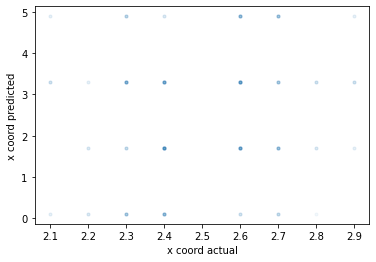

In [81]:
plt.figure()
plt.plot(coord_actual[is_hard], pred[is_hard], '.', alpha=0.05)
plt.xlabel('x coord actual')
plt.ylabel('x coord predicted')
print(scipy.stats.pearsonr(coord_actual[is_hard], pred[is_hard]))

(0.0966233486188012, 0.18245589979329974)


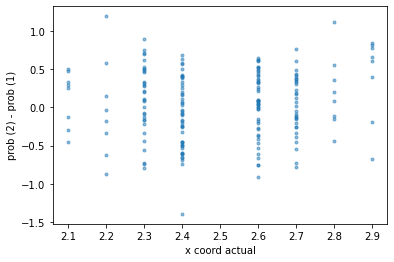

In [82]:
pdiff = prob[is_hard,2] - prob[is_hard,1]

plt.figure()

plt.plot(coord_actual[is_hard], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[is_hard], pdiff))

(0.1860365131972722, 0.045557936036997565)


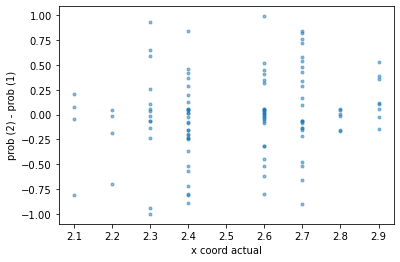

In [83]:
inds = is_hard & correct

pdiff = prob[inds,3] - prob[inds,0]

plt.figure()

plt.plot(coord_actual[inds], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[inds], pdiff))

(0.07196635167837917, 0.5367123862216652)


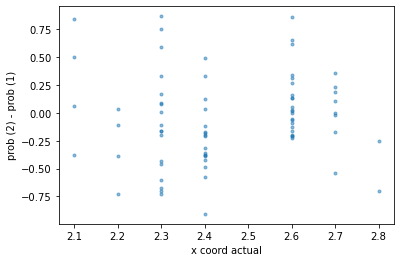

In [84]:
inds = is_hard & ~correct

pdiff = prob[inds,3] - prob[inds,0]

plt.figure()

plt.plot(coord_actual[inds], pdiff, '.', alpha=0.5)
plt.xlabel('x coord actual')
plt.ylabel('prob (2) - prob (1)')
print(scipy.stats.pearsonr(coord_actual[inds], pdiff))